In [1]:
library(fixest)
library(dplyr)
library(readr)
library(tidyr)
library(stats)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
base = read_csv('base_tpv_master.csv')

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 16078711 Columns: 26
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): document, tpv_stone, share_tpv_debit, share_tpv_chip_present, sha...
dbl  (15): tpv_total, share_tpv_credit, average_ticket_size, month, year, to...
date  (1): reference_month

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
base$uf = substr(base$municipio,1,2)

In [ ]:
m1 = feols(log_total_tpv_credit ~ log_total_tpv_credit_lag + log_total_tpv_credit_mun + media_cnpjs_por_socio + qtd_socios_no_mes | municipio + grupo_cnae_fiscal_principal + reference_month, base)

In [ ]:
summary(m1)

In [ ]:
base$yhat = predict(m1, newdata = base)         

In [ ]:
base$resid = base$log_total_tpv_credit - base$yhat

In [ ]:
hist(base$resid,breaks=100)

In [ ]:
resid_median = median(base$resid,na.rm=T)

In [ ]:
base = base %>% mutate(resid_above_median = ifelse(resid >= resid_median,1,0))

In [ ]:
base$resid_above_median = base$resid_above_median %>% replace_na(0)

In [ ]:
document_agg = base %>%   
               group_by(document) %>% summarise(qtd_above_median = sum(resid_above_median))

In [ ]:
hist(document_agg$qtd_above_median,breaks=10)

In [ ]:
quantile(document_agg$qtd_above_median)

In [ ]:
document_winners = document_agg %>% filter(qtd_above_median %in% c(11)) %>% pull(document)

In [ ]:
base_winners = base %>% filter(document %in% document_winners)

In [ ]:
# Filtrando 'para os documentos que constam como ativos

In [49]:
base_ativos = read_csv('base_ativos.csv')

Rows: 7701727 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): DocumentNumber, Status
dttm (1): LastModifiedDate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [50]:
base_ativos = base_ativos %>% pull(DocumentNumber)

In [51]:
base_winners_active = base_winners %>% filter(document %in% base_ativos) 

In [52]:
# % de ativos na base de vencedores
((base_winners_active %>% nrow())/(base_winners %>% nrow()))*100

[1] 67.98128

In [53]:
write_csv(base_winners_active,'document_winners.csv')

In [ ]:
doc_ex = base_winners %>% filter(document == document_winners[10])

In [ ]:
library(ggplot2)

# Supondo que seu dataframe se chama doc_ex
ggplot(doc_ex, aes(x = reference_month)) +
  geom_line(aes(y = log_total_tpv_credit, color = "Realizado"), size = 1) +
  geom_line(aes(y = yhat, color = "Projetado"), linetype = "dashed", size = 1) +
  scale_color_manual(
    values = c("Realizado" = "blue", "Projetado" = "red"),
    name = "Legenda"
  ) +
  labs(
    x = "Mês de Referência",
    y = "Log do Faturamento",
    title = "Comparativo entre Valor Realizado e Projetado"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5),
    legend.position = "bottom"
  )


In [ ]:
# Diagnóstico de resíduos positivos sendo mais possíveis em empresas maiores 
## Solução proposta: adicionar o decil do faturamento da firma, considerando a média do log do faturamento no período disponível

In [ ]:
ggplot() +
  geom_histogram(aes(x = base$log_total_tpv_credit, y = ..density..),
                 bins = 100, fill = "red", alpha = 0.5) +
  geom_histogram(aes(x = base_winners$log_total_tpv_credit, y = ..density..),
                 bins = 100, fill = "blue", alpha = 0.5) +
  labs(title = "Distribuição do log_total_tpv_credit",
       x = "log_total_tpv_credit", y = "Densidade") +
  theme_minimal()


In [ ]:
base_agg = base %>%
  group_by(document) %>%
  summarise(media_faturamento = mean(log_total_tpv_credit, na.rm = TRUE)) %>%
  mutate(decil_media_faturamento = ntile(media_faturamento, 10))

In [ ]:
base = base %>% left_join(.,base_agg,by=("document"))

In [ ]:
m2 = feols(log_total_tpv_credit ~ log_total_tpv_credit_lag + log_total_tpv_credit_mun + media_cnpjs_por_socio + qtd_socios_no_mes | municipio + grupo_cnae_fiscal_principal + reference_month + decil_media_faturamento, base)

In [ ]:
summary(m2)

In [ ]:
base$yhat = predict(m2, newdata = base)         

In [ ]:
base$resid = base$log_total_tpv_credit - base$yhat

In [ ]:
resid_median = median(base$resid,na.rm=T)

In [ ]:
base = base %>% mutate(resid_above_median = ifelse(resid >= resid_median,1,0))

In [ ]:
base$resid_above_median = base$resid_above_median %>% replace_na(0)

In [ ]:
document_agg = base %>%   
               group_by(document) %>% summarise(qtd_above_median = sum(resid_above_median))

In [ ]:
hist(document_agg$qtd_above_median,breaks=11)

In [ ]:
document_winners = document_agg %>% filter(qtd_above_median %in% c(11)) %>% pull(document)

In [ ]:
base_winners = base %>% filter(document %in% document_winners)

In [ ]:
ggplot() +
  geom_histogram(aes(x = base$log_total_tpv_credit, y = ..density..),
                 bins = 100, fill = "red", alpha = 0.5) +
  geom_histogram(aes(x = base_winners$log_total_tpv_credit, y = ..density..),
                 bins = 100, fill = "blue", alpha = 0.5) +
  labs(title = "Distribuição do log_total_tpv_credit",
       x = "log_total_tpv_credit", y = "Densidade") +
  theme_minimal()


In [4]:
base_agg = base %>%
  group_by(document) %>%
  summarise(media_faturamento = mean(log_total_tpv_credit, na.rm = TRUE)) %>%
  mutate(decil_media_faturamento = ntile(media_faturamento, 10))

In [5]:
base = base %>% left_join(.,base_agg,by=("document"))

In [6]:
m2 = feols(log_total_tpv_credit ~ log_total_tpv_credit_lag:factor(decil_media_faturamento) + log_total_tpv_credit_mun:factor(decil_media_faturamento) + media_cnpjs_por_socio:factor(decil_media_faturamento) + qtd_socios_no_mes:factor(decil_media_faturamento) | municipio + grupo_cnae_fiscal_principal + reference_month + decil_media_faturamento, base, cluster = ~ municipio)

NOTES: 3,992,625 observations removed because of NA and infinite values (LHS: 1,749,506, RHS: 3,329,802, Fixed-effects: 217,430).
       3/0/0/0 fixed-effect singletons were removed (3 observations).



In [8]:
base$yhat = predict(m2, newdata = base)         

In [9]:
base$resid = base$log_total_tpv_credit - base$yhat

In [10]:
base_resid_decil = base %>% group_by(decil_media_faturamento) %>% summarise(mean_resid = mean(resid,na.rm=T),
                                                                           sd_resid = sd(resid,na.rm=T))

In [12]:
base_ = base %>% left_join(.,base_resid_decil,by=c("decil_media_faturamento")) %>% mutate(resid_std = 2*((resid - mean_resid)/sd_resid)) %>% mutate(resid_above_2_std = ifelse(resid_std >= 1.28,1,0))

In [13]:
base_$resid_above_2_std = base_$resid_above_2_std %>% replace_na(0)

In [14]:
base_resid_decil = base_ %>% group_by(document,decil_media_faturamento) %>% summarise(total_resid_above_2_std = sum(resid_above_2_std))

`summarise()` has grouped output by 'document'. You can override using the
`.groups` argument.


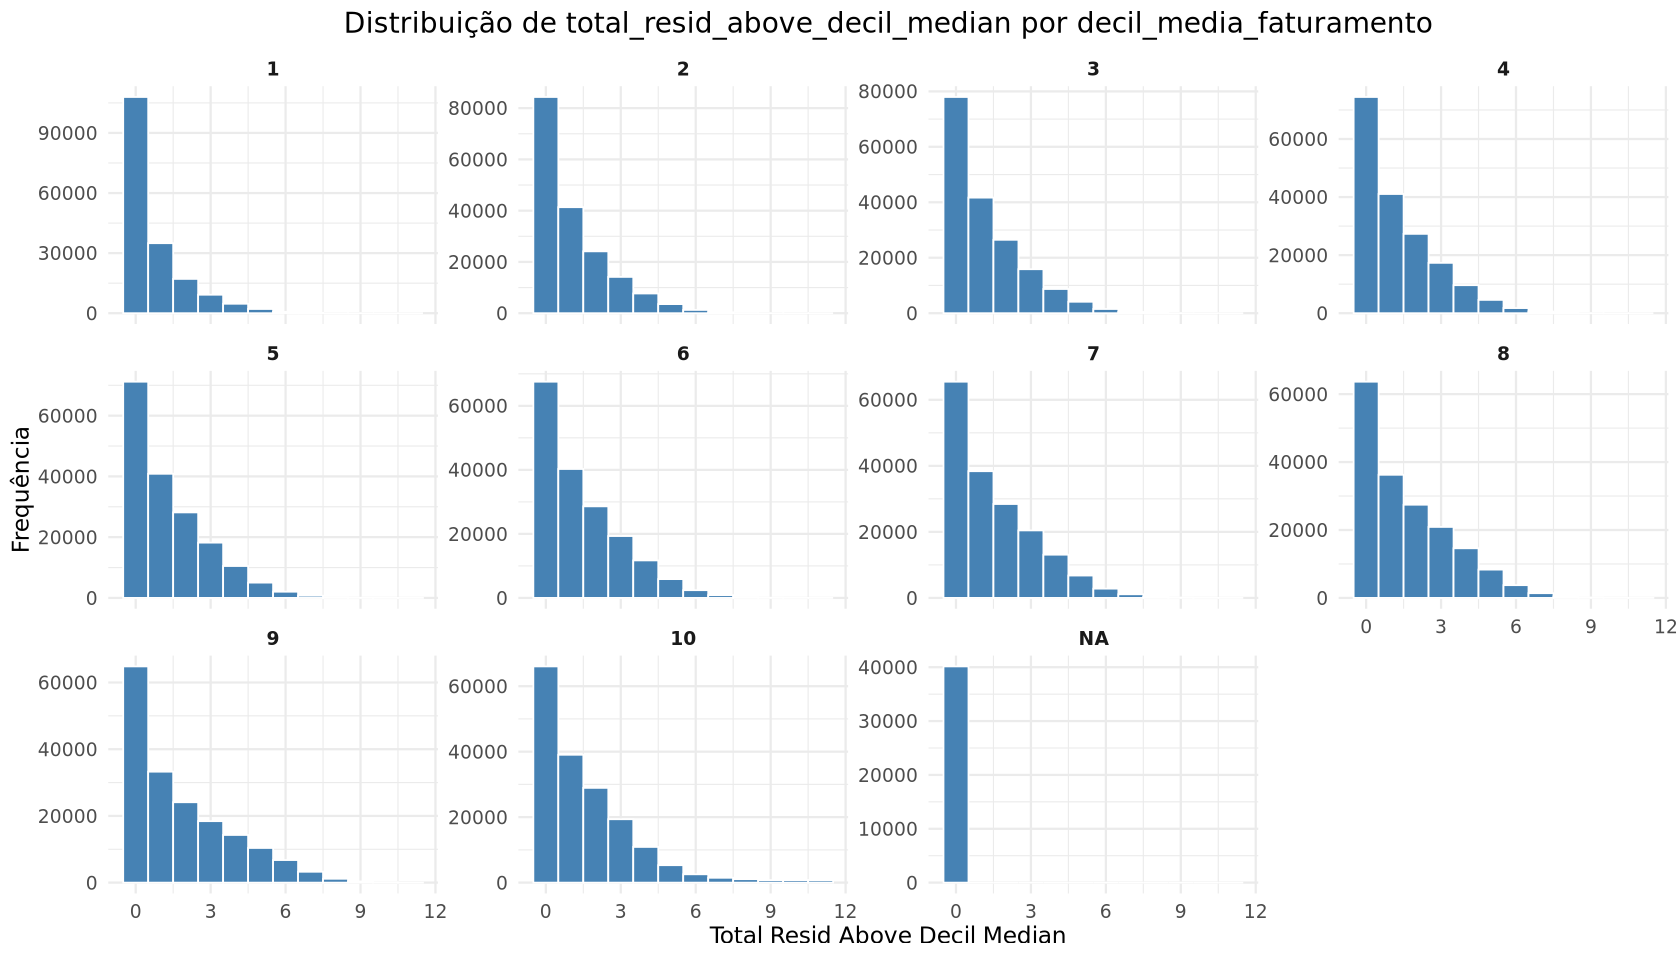

In [15]:
options(repr.plot.width = 14, repr.plot.height = 8)

base_resid_decil %>%
  ggplot(aes(x = total_resid_above_2_std)) +
  geom_histogram(bins = 12, fill = "steelblue", color = "white") +
  facet_wrap(~ decil_media_faturamento, scales = "free_y") +
  labs(
    title = "Distribuição de total_resid_above_decil_median por decil_media_faturamento",
    x = "Total Resid Above Decil Median",
    y = "Frequência"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5),
    strip.text = element_text(face = "bold")
  )

In [45]:
document_winners = base_resid_decil %>% filter(total_resid_above_2_std %in% c(6,7,8,9,10,11)) %>% pull(document)

In [46]:
length(document_winners)

[1] 42821

In [47]:
base_winners = base_ %>% filter(document %in% document_winners)

Warning message:
“Removed 1749506 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 3148 rows containing non-finite values (`stat_bin()`).”


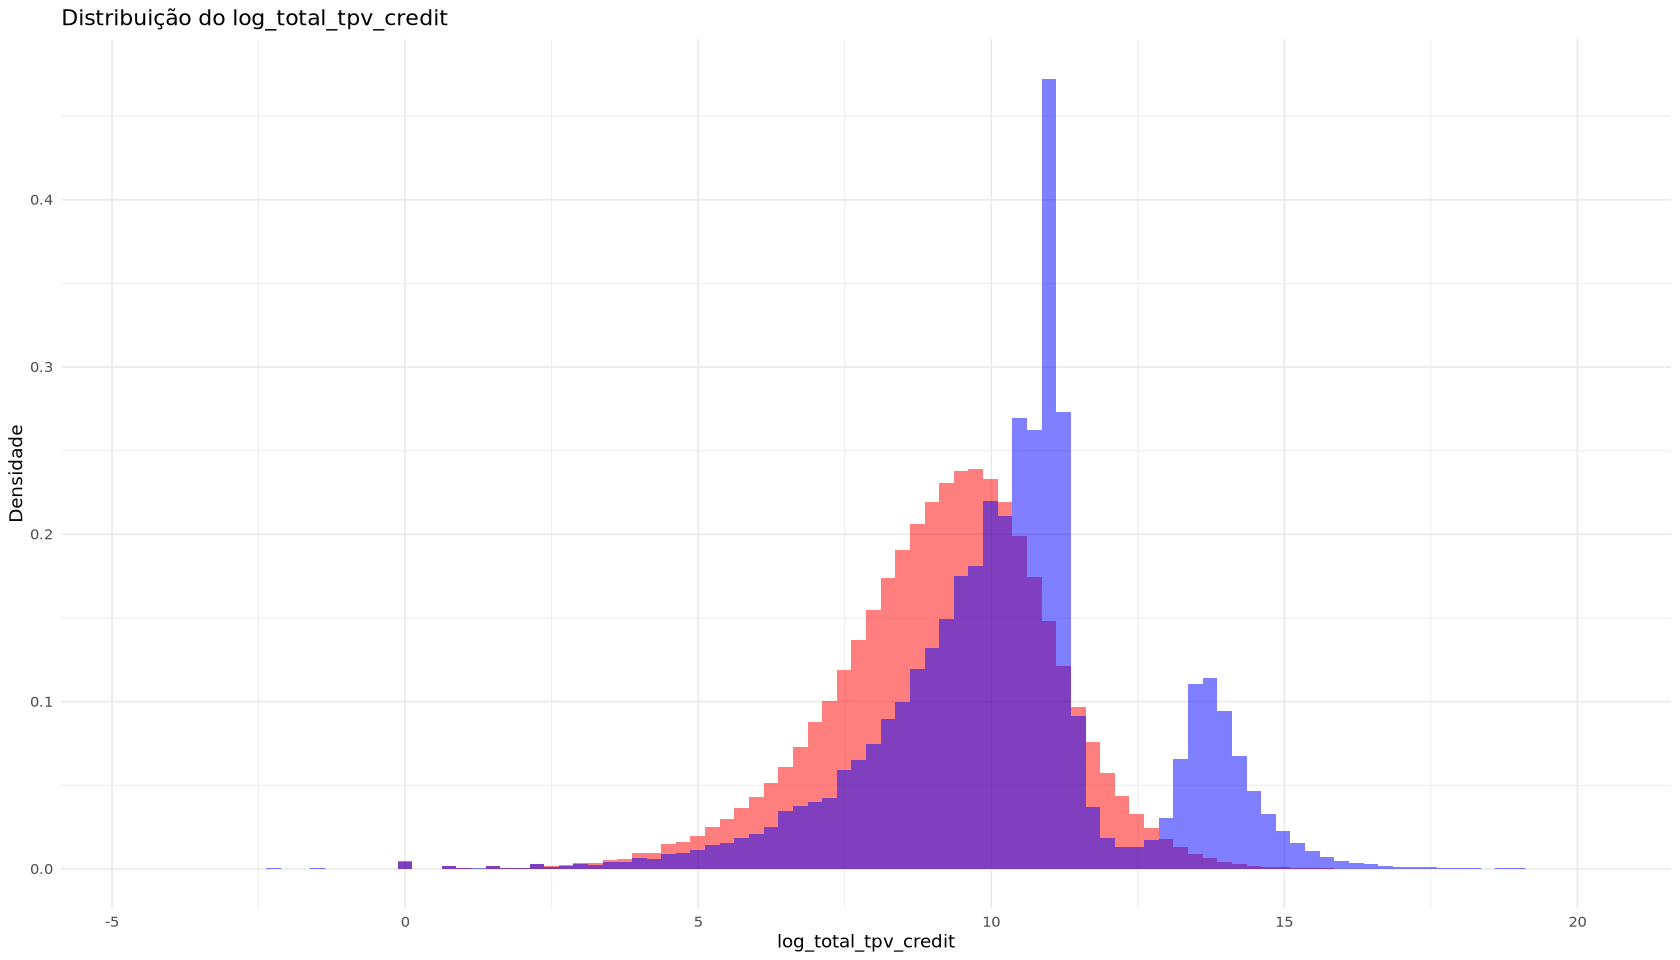

In [48]:
ggplot() +
  geom_histogram(aes(x = base_$log_total_tpv_credit, y = ..density..),
                 bins = 100, fill = "red", alpha = 0.5) +
  geom_histogram(aes(x = base_winners$log_total_tpv_credit, y = ..density..),
                 bins = 100, fill = "blue", alpha = 0.5) +
  labs(title = "Distribuição do log_total_tpv_credit",
       x = "log_total_tpv_credit", y = "Densidade") +
  theme_minimal()
